In [2]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler


# Metrics and Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,
    mean_poisson_deviance, mean_gamma_deviance, accuracy_score
)

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# File Handling
import os

# Math
import math

# Time series models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Statistics
from scipy.stats import f_oneway

# Neural Network
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Avoiding warnings from tensor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential
from keras.layers import Dense, LSTM

2023-12-17 18:28:01.991024: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 18:28:01.991083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 18:28:01.992131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class BTC(object):
    def __init__(self, dataset, granularity):
        if not isinstance(dataset, pd.DataFrame):
            raise ValueError("Input 'dataset' must be a pandas DataFrame.")
        
        self.dataset = dataset.copy()
        self.granularity = granularity
        
        self.dataset['time'] = pd.to_datetime(self.dataset['time'])
        self.dataset.set_index('time', inplace=True)
        
        
    def __str__(self):
        return 'BTC-' + str(self.granularity)
    
    def show_dataset(self, head=False, tail=False):       
        if head:
            return self.dataset.head(head)
        
        elif tail:
            return self.dataset.tail(tail)
        
        else:
            return self.dataset
            
    def split_data(self, feature_columns, target_column, train_ratio=0.7):
        training_size = int(len(self.dataset) * train_ratio)
        
        features = self.dataset[feature_columns].iloc[:-1, :]
        target = self.dataset[target_column].iloc[1:]

        
        (X_train, X_test) = (features.iloc[:training_size], features.iloc[training_size:])
        
        X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
        X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        
        
        (y_train, y_test) = (target.iloc[:training_size], target.iloc[training_size:])

        return X_train_reshaped, y_train, X_test_reshaped, y_test
    
    def plot_candle(self):
        mpf.plot(self.dataset, type='candle', style='yahoo', figsize=(20,10))
    
    def plot_heatmap(self):    
        plt.figure(figsize=(10,5))

        correlation = self.dataset.corr()
        sns.heatmap(correlation, annot=True)

        plt.show()
        
    def show_nulls(self):
        return self.dataset.isna().sum()
    
    def check_time_gaps(self):
        return (self.dataset.index[1:]-self.dataset.index[:-1]).value_counts().head()

    def dicker_fuller(self, column):
        print ('Dickey-Fuller Test indicates:')
        df_test = adfuller(self.dataset[column], regression='ct', autolag='AIC')
        output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        print(output)

    def print_granularity(self, unit='seconds'):
        units = {'seconds': 1, 'minutes': 1/60, 'hours': 1/3600}
        
        interval = self.granularity * units[unit]
        
        print('Intervals of {} {}'.format(interval, unit))

In [4]:
path = os.path.abspath('Datasets/BTC-EUR')

BTC_3600 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-3600.csv')), 3600)

In [38]:
from keras.layers import TimeDistributed

class LSTMModel(object):
    def __init__(self):
        self.model = self.build_model()
        
    def build_model(self):
        model = Sequential()
        
        model.add(LSTM(units=1024, activation='relu',return_sequences=True))
        model.add(LSTM(units=512, activation='relu', return_sequences=True))
        model.add(LSTM(units=256, activation='relu',return_sequences=True))
        model.add(LSTM(units=128, activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(1)))
        
        return model
        
    def compile_model(self, optimizer='adam', loss='mse', metrics='mae'):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    def train_model(self, X_train, y_train, epochs=10, batch_size=32, validation_data=None):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data)

    def evaluate_model(self, X_test, y_test):
        return self.model.evaluate(X_test, y_test)

    def predict(self, X_new_data):
        return self.model.predict(X_new_data)

    def plot_predictions(self, BTC, train_set, test_predict):
        test_predict = test_predict.reshape(-1,1)
        train_shape = train_set.shape[0]

        # Your original code for plotting the black and red lines
        fig, ax = plt.subplots(figsize=(15, 6))
        sns.lineplot(x=BTC.dataset.index[:train_shape], y=BTC.dataset['close'][:train_shape], color='black')
        sns.lineplot(x=BTC.dataset.index[train_shape:], y=BTC.dataset['close'][train_shape:], color='red')

        # Plot the test data on top of the red line
        sns.lineplot(x=BTC.dataset.index[train_shape+1:], y=test_predict[:, 0], color='blue')

        # Formatting
        ax.set_title('BitCoin Value Evolution', fontsize=20, loc='center', fontdict=dict(weight='bold'))
        ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
        ax.set_ylabel('Daily Sales', fontsize=16, fontdict=dict(weight='bold'))
        plt.tick_params(axis='y', which='major', labelsize=16)
        plt.tick_params(axis='x', which='major', labelsize=16)

        # Customize legend labels and colors
        plt.legend(loc='upper right', labels=['train', 'test', 'predicted test'], 
                   handles=[plt.Line2D([0], [0], color='black', label='train'),
                            plt.Line2D([0], [0], color='red', label='test'),
                            plt.Line2D([0], [0], color='blue', label='predicted test')])

        plt.show()

        

In [6]:
model = LSTMModel()

features = ['open', 'close', 'high', 'low']
targets = ['close']

X_train, y_train, X_test, y_test = BTC_3600.split_data(features, targets, train_ratio=0.7)

model.compile_model()

model.train_model(X_train, y_train.values, epochs=1, batch_size=32, validation_data=(X_test, y_test.values))

model.evaluate_model(X_test, y_test)

142/142 [==============================] - 1s 6ms/step - loss: 15854.4707 - mae: 82.2891


[15854.470703125, 82.28905487060547]

142/142 [==============================] - 1s 6ms/step


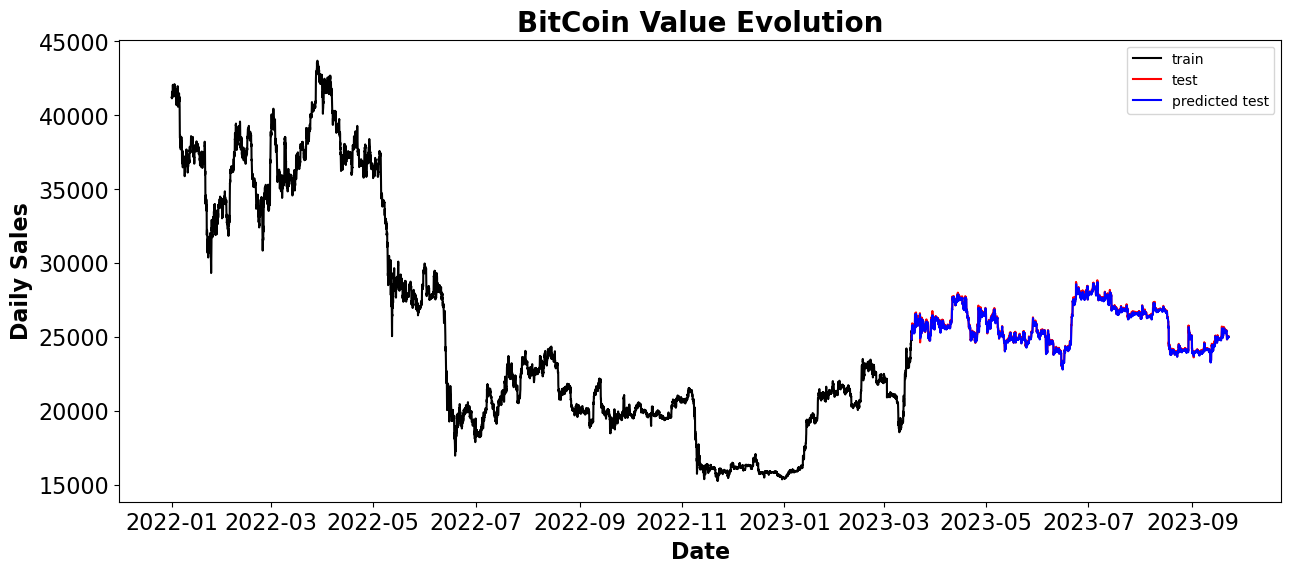

In [7]:
predictions = model.predict(X_test)

model.plot_predictions(BTC_3600, X_train, predictions)

In [8]:
error = model.evaluate_model(X_test, y_test)[0]
print(f"\nMSE: {error}")

142/142 [==============================] - 1s 6ms/step - loss: 15854.4707 - mae: 82.2891

MSE: 15854.470703125


## To Be implemented

+ normalitzar les dades
+ fer zoom del plot
+ períodes més petits per calcular correlacions
+ model simple per anar millorant el model
+ model cutre de xarxa neuronal per fer comparacions
+ calcular els errors dels models

### Zooming data

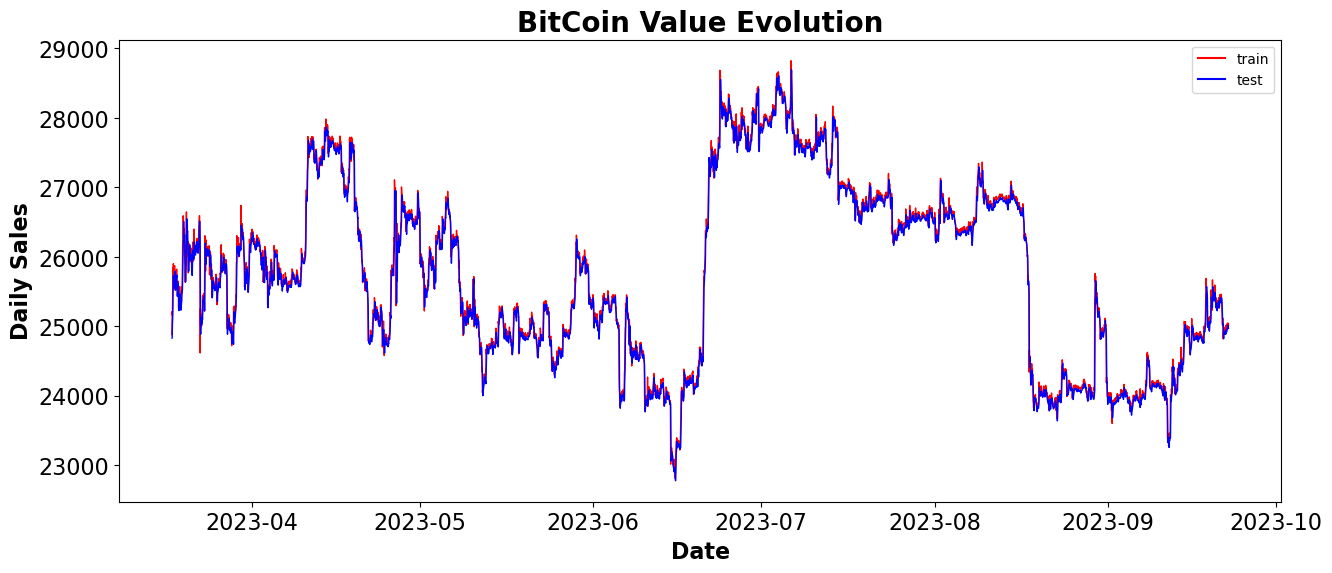

In [9]:
train_shape = X_train.shape[0]

size=1

fig, ax = plt.subplots(figsize=(15, 6))


sns.lineplot(x=BTC_3600.dataset.index[train_shape:], y=BTC_3600.dataset['close'][train_shape:], color='red', linewidth=size)
sns.lineplot(x=BTC_3600.dataset.index[train_shape+1:], y=predictions.reshape(-1), color='blue', linewidth=size)

# Formatting
ax.set_title('BitCoin Value Evolution', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Daily Sales', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# Customize legend labels and colors
plt.legend(loc='upper right', labels=['train', 'test', 'predicted test'], 
           handles=[plt.Line2D([0], [0], color='red', label='test'),
                    plt.Line2D([0], [0], color='blue', label='predicted test')])

plt.show()




### Data normalized

In [10]:
min_max_scaler = MinMaxScaler()
normalized_data = pd.DataFrame(min_max_scaler.fit_transform(BTC_3600.dataset), columns=BTC_3600.dataset.columns)
time_indexes = BTC_3600.dataset.index

normalized_data['time'] = time_indexes

BTC_normalized = BTC(normalized_data, 3600)

In [11]:
model = LSTMModel()

features = ['open', 'close', 'high', 'low']
targets = ['close']

X_train, y_train, X_test, y_test = BTC_normalized.split_data(features, targets, train_ratio=0.7)

model.compile_model()

model.train_model(X_train, y_train.values, epochs=1, batch_size=32, validation_data=(X_test, y_test.values))

model.evaluate_model(X_test, y_test)

142/142 [==============================] - 1s 6ms/step - loss: 2.8941e-05 - mae: 0.0041


[2.8941043638042174e-05, 0.004094062373042107]

142/142 [==============================] - 1s 6ms/step


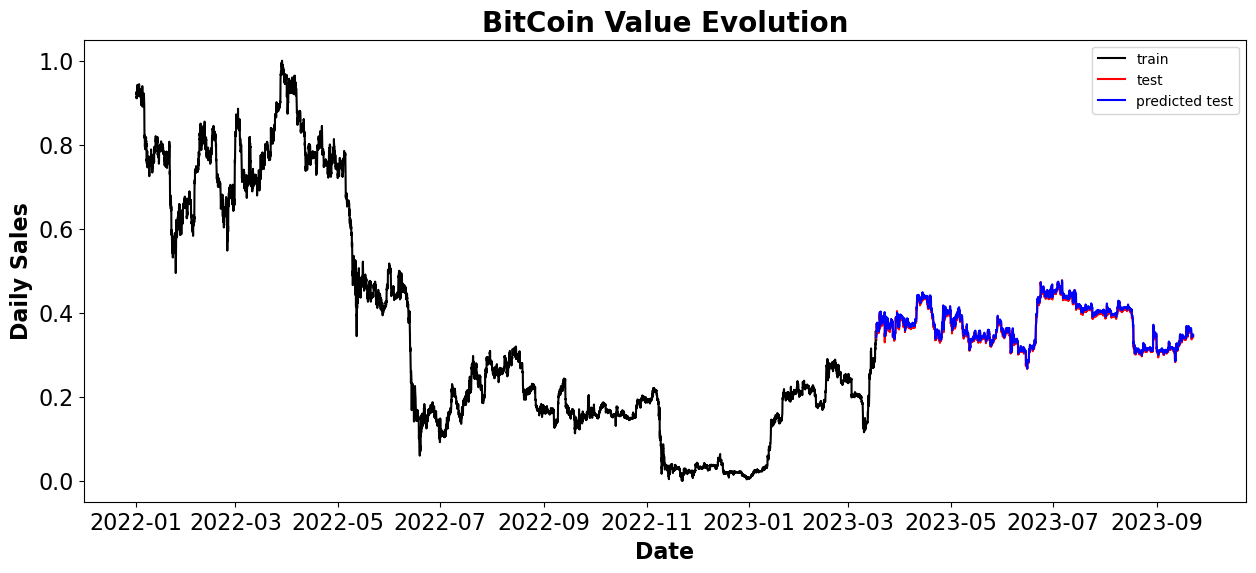

In [12]:
predictions = model.predict(X_test)

model.plot_predictions(BTC_normalized, X_train, predictions)

In [13]:
len(X_test)

4531

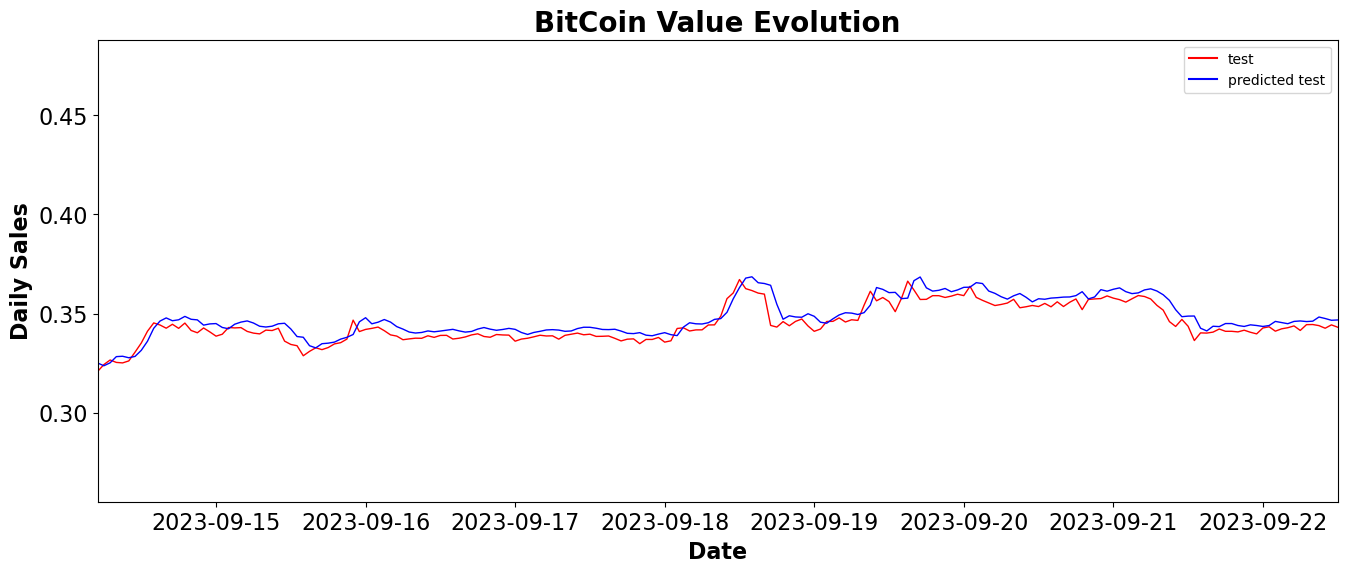

In [14]:
train_shape = X_train.shape[0]

size=1

fig, ax = plt.subplots(figsize=(16, 6))


sns.lineplot(x=BTC_normalized.dataset.index[train_shape:], y=BTC_normalized.dataset['close'][train_shape:], color='red', linewidth=size)
sns.lineplot(x=BTC_normalized.dataset.index[train_shape+1:], y=predictions.reshape(-1), color='blue', linewidth=size)

# Formatting
ax.set_title('BitCoin Value Evolution', fontsize=20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Date', fontsize=16, fontdict=dict(weight='bold'))
ax.set_ylabel('Daily Sales', fontsize=16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)

# Customize legend labels and colors
plt.legend(loc='upper right', labels=['test', 'predicted test'], 
           handles=[plt.Line2D([0], [0], color='red', label='test'),
                    plt.Line2D([0], [0], color='blue', label='predicted test')])

last_dates = BTC_3600.dataset.index[-200:]

ax.set_xlim(last_dates[0], last_dates[-1])  # Replace 'start_date' and 'end_date' with the desired range


plt.show()

In [15]:
error = model.evaluate_model(X_test, y_test)[0]
print(f"\nMSE: {error}")

142/142 [==============================] - 1s 6ms/step - loss: 2.8941e-05 - mae: 0.0041

MSE: 2.8941043638042174e-05


### Checking correlations

In [16]:
def compare_correlations(BTC):
    length = int(len(BTC.dataset))
    
    correlations = list()
    samples = list()
    
    while length > 1:
        correlation = BTC.dataset[['open', 'close']].iloc[:length].corr().iloc[0, 1]
        correlations.append(correlation)
        samples.append(length)
        
        length = int(length / 2)
        
    
    return correlations, samples

In [17]:
correlations, samples = compare_correlations(BTC_3600)

In [18]:
def plot_correlations(correlations, samples):
    plt.figure()
    plt.plot(samples, correlations, color='orange')
    plt.title('Correlation evolution')
    plt.xlabel('Number of samples used')
    plt.ylabel('Correlation')
    
    plt.gca().invert_xaxis()
    
    plt.show()

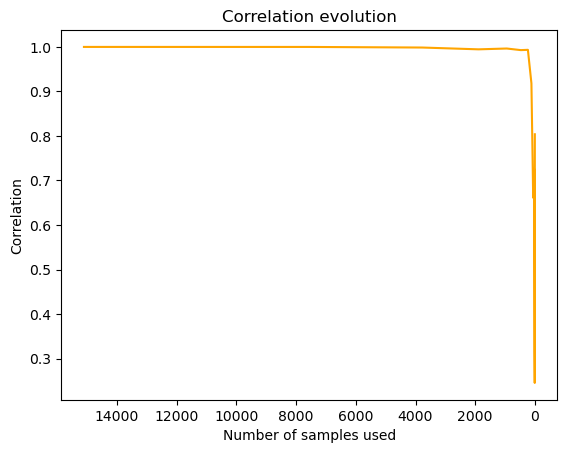

In [19]:
plot_correlations(correlations, samples)

### NEW APPROACH: 

trying to make good predictions with only 1, 5, 10, ... days. 

In [54]:
path = os.path.abspath('Datasets/BTC-EUR')

BTC_reduced = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-3600.csv')).iloc[:20], 3600)

In [55]:
BTC_reduced.dataset

,low,high,open,close,volume
time,,,,,
2022-01-01 01:00:00,41022.31,41333.46,41090.37,41214.76,13.926502
2022-01-01 02:00:00,41173.50,41338.63,41214.62,41241.12,11.374560
2022-01-01 03:00:00,41196.65,41316.89,41249.52,41230.15,11.587862
2022-01-01 04:00:00,41063.69,41282.21,41227.91,41131.00,6.445171
2022-01-01 05:00:00,41096.50,41856.83,41128.30,41553.13,20.705705
2022-01-01 06:00:00,41337.33,41670.16,41566.25,41369.45,11.460510
2022-01-01 07:00:00,41309.94,41616.62,41370.03,41588.09,9.123570
2022-01-01 08:00:00,41462.62,41697.23,41576.68,41499.63,11.687139
2022-01-01 09:00:00,41341.42,41578.50,41506.82,41518.38,10.801053


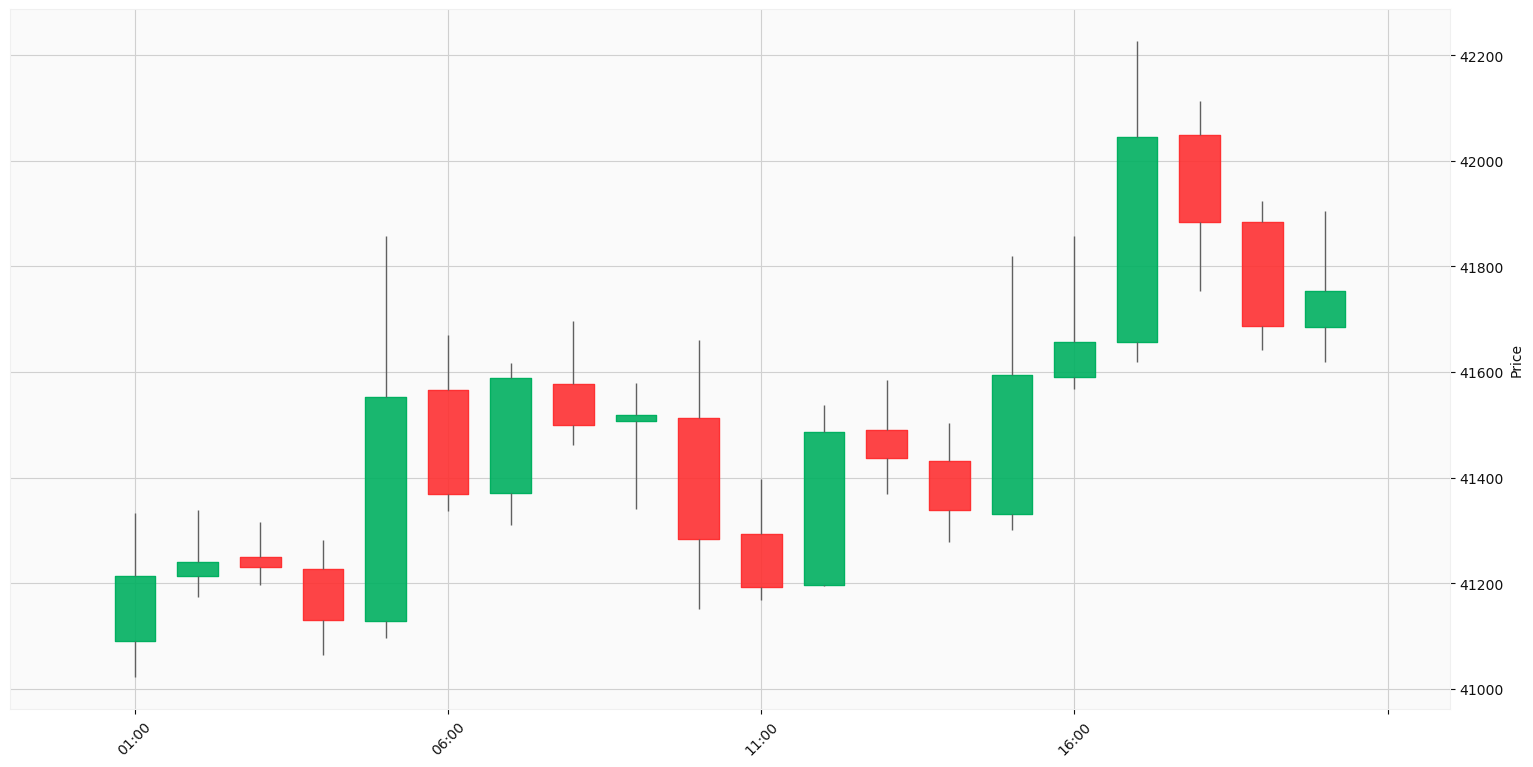

In [56]:
BTC_reduced.plot_candle()

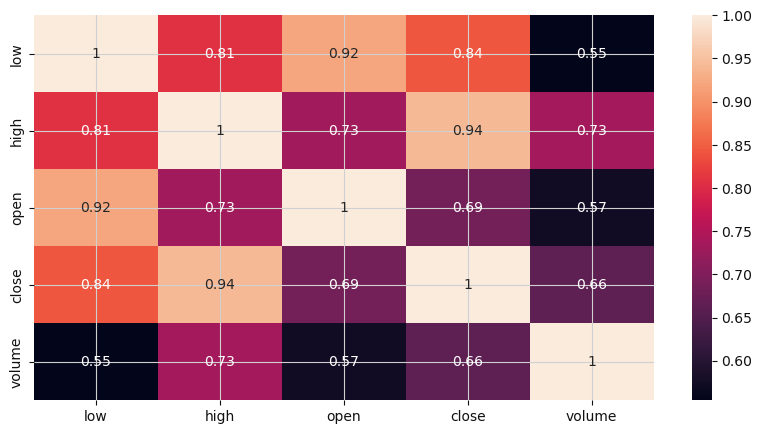

In [57]:
BTC_reduced.plot_heatmap()

In [42]:
path = os.path.abspath('Datasets/BTC-EUR')

BTC_reduced_3600 = BTC(pd.read_csv(os.path.join(path, 'BTC-EUR-3600.csv')).iloc[:10], 3600)

min_max_scaler = MinMaxScaler()
normalized_data = pd.DataFrame(min_max_scaler.fit_transform(BTC_reduced_3600.dataset), columns=BTC_reduced_3600.dataset.columns)
time_indexes = BTC_reduced_3600.dataset.index

normalized_data['time'] = time_indexes

BTC_reduced_normalized = BTC(normalized_data, 3600)

In [43]:
model = LSTMModel()

features = ['open', 'close', 'high', 'low']
targets = ['close']

X_train, y_train, X_test, y_test = BTC_reduced_normalized.split_data(features, targets, train_ratio=0.7)

model.compile_model()

model.train_model(X_train, y_train.values, epochs=1, batch_size=32, validation_data=(X_test, y_test.values))

model.evaluate_model(X_test, y_test)

1/1 [==============================] - 0s 397ms/step - loss: 0.4118 - mae: 0.5883


[0.41181430220603943, 0.5882667899131775]

In [58]:
BTC_3600.dataset

,low,high,open,close,volume
time,,,,,
2022-01-01 01:00:00,41022.31,41333.46,41090.37,41214.76,13.926502
2022-01-01 02:00:00,41173.50,41338.63,41214.62,41241.12,11.374560
2022-01-01 03:00:00,41196.65,41316.89,41249.52,41230.15,11.587862
2022-01-01 04:00:00,41063.69,41282.21,41227.91,41131.00,6.445171
2022-01-01 05:00:00,41096.50,41856.83,41128.30,41553.13,20.705705
...,...,...,...,...,...
2023-09-22 08:00:00,25029.65,25116.09,25043.28,25048.48,13.930500
2023-09-22 09:00:00,25019.40,25058.89,25046.90,25032.72,12.537023
2023-09-22 10:00:00,24985.71,25048.77,25031.95,24995.34,13.269391
